# Image captioning model - Tune
Following guide from [HuggingFace: Image captioning](https://huggingface.co/docs/transformers/main/en/tasks/image_captioning)

## Libraries & packages

In [1]:
#!pip install transformers datasets evaluate -q
#!pip install jiwer -q
#!pip install transformers[torch]

In [2]:
import pandas as pd
import csv
import json

from datasets import load_dataset

from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np

from transformers import AutoProcessor
from transformers import AutoModelForCausalLM

from evaluate import load
import torch

from transformers import TrainingArguments, Trainer

from PIL import Image

from huggingface_hub import notebook_login

In [3]:
notebook_login()

##  Import dataset
Generate a {image-caption} pairs metadata file in JSON format for the model.

In [37]:
# Path to folder with images
img_path = '../Datasets/childrens-books'

# Path to file with images' description
# Original is CSV format
img_path_csv = '../Manual Image captioning/childrens-books-captions-unicode.csv'
# Generated JSON file path
img_path_json = img_path + '/metadata.jsonl'

In [49]:
# Function to convert a CSV to JSON
# Takes the file paths as arguments
def make_json(csvFilePath, jsonFilePath):
     
    # create a list
    data = []
     
    # Open a csv reader called DictReader
    with open(csvFilePath) as csvf:
        csvReader = csv.DictReader(csvf)
         
        # Add each row to data list as dictionary
        for row in csvReader:
            data.append(row)
 
    # Open a json writer, and use the json.dumps()
    # function to dump data
    with open(jsonFilePath, 'w') as jsonf:
        for item in data:
            jsonf.write(json.dumps(item) + "\n")

In [51]:
# Call the make_json function
# Saves the json file from csv original file
make_json(img_path_csv, img_path_json)

In [52]:
# Load dataset
img_ds = load_dataset('imagefolder', data_dir = img_path)
# Print image dataset info to confirm it was correctly created
img_ds

Resolving data files:   0%|          | 0/1711 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to C:/Users/caprattr/.cache/huggingface/datasets/imagefolder/default-aa57e3a315573ed1/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 1710
    })
})

## Split dataset into train & test sets
Split dataset into train and test, test size of 25% of total images.

In [53]:
# Split dataset into train and test, test size of 25% of total images
img_ds_split = img_ds['train'].train_test_split(test_size=0.25)
train_ds = img_ds_split['train']
test_ds = img_ds_split['test']

In [54]:
# Function to plot images
def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis('off')

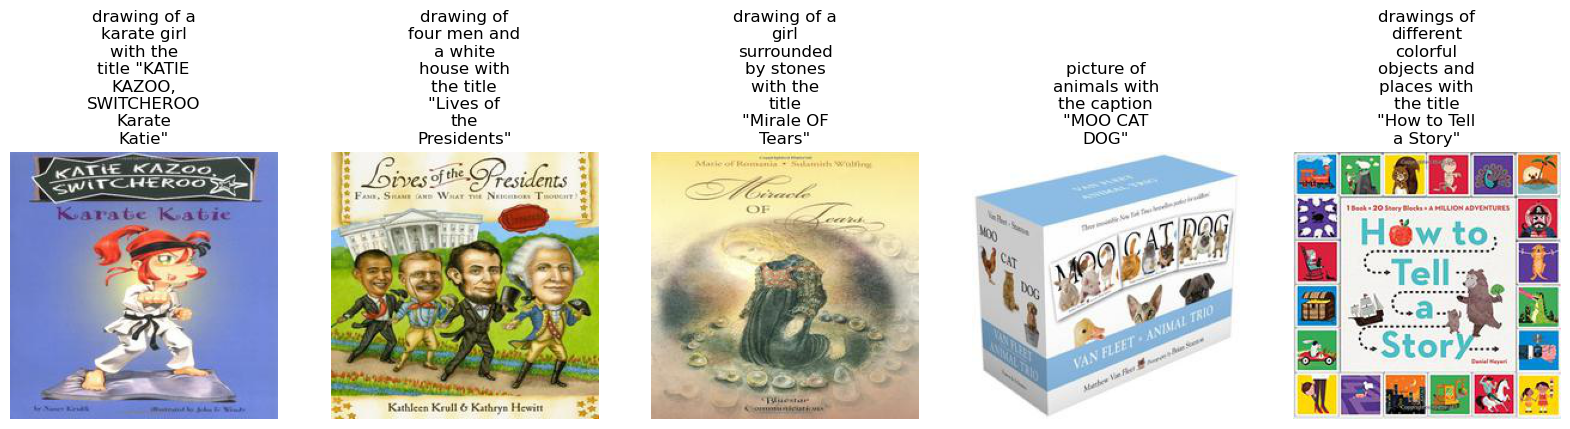

In [55]:
# Print some images from train dataset
sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions = [train_ds[i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

## Preprocess dataset
Since the dataset has two modalities (image and text), the pre-processing pipeline will preprocess images and the captions.

In [56]:
# Load the processor class associated with the model we are about to fine-tune
checkpoint = 'microsoft/git-large-r-coco'
processor = AutoProcessor.from_pretrained(checkpoint)

C:\Users\caprattr\AppData\Local\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\caprattr\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


The processor will internally pre-process the image (which includes resizing, and pixel scaling) and tokenize the caption.

In [57]:
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs

In [58]:
# Process train and test datasets
train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

## Load a base model
Load the “microsoft/git-large-r-coco” into a AutoModelForCausalLM object.

In [59]:
model = AutoModelForCausalLM.from_pretrained(checkpoint)

## Define evaluation type
Image captioning models are typically evaluated with the Rouge Score or Word Error Rate. We will use the **Word Error Rate (WER)**.

**Limitation of WER:** provides no details on the nature of translation errors and further work is therefore required to identify the main source(s) of error and to focus any research effort.

In [60]:
# Load WER 
wer = load("wer")

In [61]:
# Function to evaluate with WER
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

## Train model

Define the training arguments using TrainingArguments.

In [63]:
# Get base model name
model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-childrensbooks",
    learning_rate=5e-5,
    num_train_epochs=50,
    #fp16=True,    # For GPU only
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    remove_unused_columns=False,
    push_to_hub=True,
    label_names=["labels"],
    load_best_model_at_end=True,
)

Pass the arguments along with the datasets and the model to Trainer.

In [64]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

In [ ]:
# Train the model
trainer.train()

## Inference

In [31]:
# Function to prepare image for the model and caption it
def caption_image(img_path):
    # Prepare image for the model
    image = Image.open(img_path)
    
    # Call generate and decode the predictions
    device = "cuda" if torch.cuda.is_available() else "cpu"

    inputs = processor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values
    
    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    # Return image and caption
    return image, generated_caption

In [34]:
# Define a list of images
imgs_validation = ['0545077974.jpg','0545533643.jpg','0545834910.jpg','0553508504.jpg','0670887102.jpg']

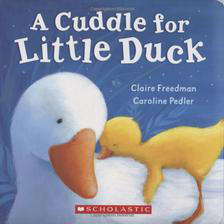

Generated caption:  children's drawing of a yellow dog with the title " a little duck "




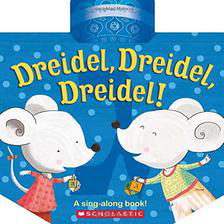

Generated caption:  children's drawing of two dogs wearing clothes around the title " charlie the dog "




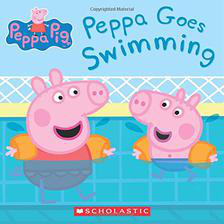

Generated caption:  children's drawing of two pigs with the caption " charlie the piggy "




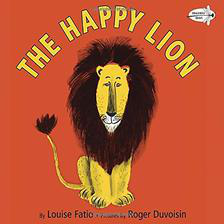

Generated caption:  children's drawing of a yellow lion with the caption " the happy lion "




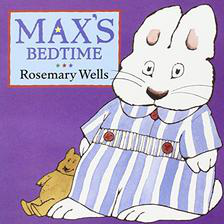

Generated caption:  children's drawing of a dog wearing a white shirt and the caption " charlie's bedtime "




In [38]:
# Caption test images
for img in imgs_validation:
    image, generated_caption = caption_image(img)
    image.show()
    print('\033[1mGenerated caption: \033[0m',generated_caption)
    print('\n')